In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [2]:
all_transactions = feather.read_dataframe('all_transactions')

In [3]:
all_transactions.drop('cat2_dum_nan',axis=1,inplace=True) 

In [4]:
train = pd.read_csv('C:\\kdata\\train.csv')

In [5]:
train['first_active_month_coded'] = train['first_active_month'].astype(np.datetime64)

train['first_active_month_coded'] = (train['first_active_month_coded'].dt.year-2011)*12+train['first_active_month_coded'].dt.month

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


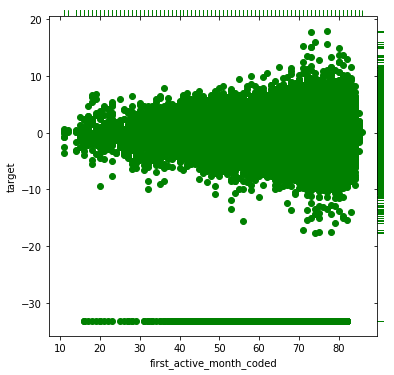

In [7]:
grid = sns.JointGrid(train['first_active_month_coded'], train['target'], space=0, height=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

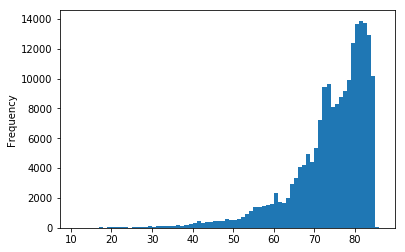

In [8]:
train['first_active_month_coded'].plot.hist(bins=75)

In [9]:
train['client_wave'] = (train.first_active_month_coded <=37) + \
                       ((train.first_active_month_coded >= 38) & (train.first_active_month_coded <= 52))*2+\
                       ((train.first_active_month_coded >= 53) & (train.first_active_month_coded <= 62))*3+\
                       ((train.first_active_month_coded >= 63) & (train.first_active_month_coded <= 69))*4+\
                       ((train.first_active_month_coded >= 70) & (train.first_active_month_coded <= 77))*5+\
                       ((train.first_active_month_coded >= 78) & (train.first_active_month_coded <= 86))*6
train['during_promo'] = (train.first_active_month_coded == 41)   + \
                        (train.first_active_month_coded == 48)*2 + \
                        (train.first_active_month_coded == 60)*3 + \
                        (train.first_active_month_coded == 68)*4 + \
                       ((train.first_active_month_coded >= 72) & (train.first_active_month_coded <= 73))*5+\
                       ((train.first_active_month_coded >= 79) & (train.first_active_month_coded <= 83))*6

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_coded,client_wave,during_promo
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,78,6,0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,73,5,5
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,68,4,4
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,81,6,6
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,83,6,6


In [11]:
# calculates the average diffence in days between shopping days
def is_active(x):
    return np.diff(np.sort(x.unique())).mean()+x.max() > 485

def mean_day_difference(x):
    return np.diff(np.sort(x.unique())).mean()

In [12]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,no_city,undefined_installments,big_installments,cat2_dum_0.0,cat2_dum_1.0,cat2_dum_2.0,cat2_dum_3.0,cat2_dum_4.0,cat2_dum_5.0,cat3_dum_A,cat3_dum_B,cat3_dum_C,cat3_dum_nan,purchase_amount_unusual,purchase_date_year,purchase_date_season,purchase_date_year_quarter,purchase_date_activity_month,purchase_date_month,purchase_date_week,purchase_date_all_weeks,purchase_date_months_week,purchase_date_end_of_the_month,purchase_date_start_of_the_month,purchase_years_day,purchase_date_day,purchase_date_weekend,purchase_date_hour,purchase_date_day_cycle,payment_per_month,position_from_start_to_finnish,month_lag_min,number_of_purchases,payment_from_end_to_begging,payment_from_begging_to_end,valid_authorization_percent,purchase_date_weekday
0,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_e020e9b302,-10,22.966691,2017-06-25 15:33:07,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,2,2,6,6,25,25,3,0,0,176,176,1,15,1,0.0,6,-15,402,10,5,0.977612,6
1,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_86ec983688,-9,22.668715,2017-07-15 12:10:45,6,10,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,7,7,28,28,2,0,0,196,196,0,12,1,0.0,7,-15,402,9,6,0.977612,5
2,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_979ed661fc,-8,22.796140,2017-08-09 22:04:29,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,8,8,32,32,1,0,0,221,221,0,22,0,0.0,8,-15,402,8,7,0.977612,2
3,1,C_ID_4e6213e9bc,11,0,0,8,M_ID_e6d5ae8ea6,-7,22.646476,2017-09-02 10:06:26,6,11,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,9,9,35,35,0,0,0,245,245,0,10,1,0.0,9,-15,402,7,8,0.977612,5
4,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_e020e9b302,-13,22.771346,2017-03-10 01:14:19,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,1,1,3,3,10,10,1,0,0,69,69,0,1,0,0.0,3,-15,402,13,2,0.977612,4


In [13]:
stats.describe(all_transactions[all_transactions.installments != 999].installments)

DescribeResult(nobs=31075202, minmax=(0, 12), mean=0.6521014087052435, variance=1.3688189086673694, skewness=5.024608929211881, kurtosis=35.97085562846439)

In [14]:
all_transactions_installments = pd.get_dummies(all_transactions.installments,prefix='installment_size')

In [16]:
all_transactions_installments['card_id'] = all_transactions.card_id
all_transactions_installments['purchase_amount'] = all_transactions.purchase_amount

In [19]:
for col in all_transactions_installments.columns[:-2]:
    all_transactions_installments[col] = all_transactions_installments[col].values * all_transactions_installments.purchase_amount.values

In [20]:
all_transactions_installments = all_transactions_installments.groupby(['card_id']).agg({x:'sum' for x in all_transactions_installments if x!='card_id' })

In [23]:
for col in all_transactions_installments[:-1]:
    all_transactions_installments[col] = all_transactions_installments[col].values / all_transactions_installments.purchase_amount.values

In [27]:
del all_transactions_installments['purchase_amount']

In [28]:
all_transactions_installments.reset_index(inplace=True)

In [33]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,no_city,undefined_installments,big_installments,cat2_dum_0.0,cat2_dum_1.0,cat2_dum_2.0,cat2_dum_3.0,cat2_dum_4.0,cat2_dum_5.0,cat3_dum_A,cat3_dum_B,cat3_dum_C,cat3_dum_nan,purchase_amount_unusual,purchase_date_year,purchase_date_season,purchase_date_year_quarter,purchase_date_activity_month,purchase_date_month,purchase_date_week,purchase_date_all_weeks,purchase_date_months_week,purchase_date_end_of_the_month,purchase_date_start_of_the_month,purchase_years_day,purchase_date_day,purchase_date_weekend,purchase_date_hour,purchase_date_day_cycle,payment_per_month,position_from_start_to_finnish,month_lag_min,number_of_purchases,payment_from_end_to_begging,payment_from_begging_to_end,valid_authorization_percent,purchase_date_weekday
0,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_e020e9b302,-10,22.966691,2017-06-25 15:33:07,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,2,2,6,6,25,25,3,0,0,176,176,1,15,1,0.0,6,-15,402,10,5,0.977612,6
1,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_86ec983688,-9,22.668715,2017-07-15 12:10:45,6,10,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,7,7,28,28,2,0,0,196,196,0,12,1,0.0,7,-15,402,9,6,0.977612,5
2,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_979ed661fc,-8,22.796140,2017-08-09 22:04:29,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,8,8,32,32,1,0,0,221,221,0,22,0,0.0,8,-15,402,8,7,0.977612,2
3,1,C_ID_4e6213e9bc,11,0,0,8,M_ID_e6d5ae8ea6,-7,22.646476,2017-09-02 10:06:26,6,11,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,3,3,9,9,35,35,0,0,0,245,245,0,10,1,0.0,9,-15,402,7,8,0.977612,5
4,1,C_ID_4e6213e9bc,11,0,0,10,M_ID_e020e9b302,-13,22.771346,2017-03-10 01:14:19,6,12,0,0,0,0,1,0,0,0,0,1,0,0,0,False,0,1,1,3,3,10,10,1,0,0,69,69,0,1,0,0.0,3,-15,402,13,2,0.977612,4


In [32]:
first_group = pd.merge(all_transactions_installments,train[['card_id','first_active_month_coded','client_wave','during_promo']])

In [34]:
all_transactions['month_coded'] = (all_transactions['purchase_date'].dt.year-2011)*12+all_transactions['purchase_date'].dt.month

In [36]:
all_transactions['first_catched_promo'] = ((all_transactions['month_coded'] >= 72) & (all_transactions['month_coded'] <= 73))
all_transactions['second_catched_promo'] = ((all_transactions['month_coded'] >= 79) & (all_transactions['month_coded'] <= 83))

In [37]:
for col in ['first_catched_promo','second_catched_promo']:
    all_transactions[col] = all_transactions[col].values * all_transactions.purchase_amount.values
    all_transactions[col] = all_transactions[col].replace({0:np.nan})

In [42]:
min_purch_month = all_transactions.groupby(['card_id']).agg({'month_coded':'min'})

In [43]:
min_purch_month.reset_index(inplace=True)

In [44]:
first_group = pd.merge(first_group,min_purch_month,on='card_id',how='left')

In [46]:
first_group.month_coded.min()

73

In [47]:
first_group.head()

,card_id,installment_size__0,installment_size__1,installment_size__2,installment_size__3,installment_size__4,installment_size__5,installment_size__6,installment_size__7,installment_size__8,installment_size__9,installment_size__10,installment_size__11,installment_size__12,installment_size__999,first_active_month_coded,client_wave,during_promo,month_coded
0,C_ID_00007093c1,0.000000,0.821454,0.067736,0.094670,0.000000,0.008015,0.008124,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,74,5,0,74
1,C_ID_0001506ef0,0.986357,0.013643,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,67,4,0,73
2,C_ID_000183fdda,0.034131,0.659889,0.094494,0.035578,0.052841,0.021091,0.044917,0.0,0.0,0.0,0.057059,0.0,0.0,0.0,81,6,6,80
3,C_ID_00027503e2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,77,5,0,77
4,C_ID_0002c7c2c1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,76,5,0,76


In [50]:
first_group['first_purch_during_activation'] = ((first_group.first_active_month_coded >= 73 ) & (first_group.first_active_month_coded == first_group.month_coded)) + ((first_group.first_active_month_coded >= 73 ) & (first_group.first_active_month_coded != first_group.month_coded))*2

In [54]:
del first_group['month_coded']

In [55]:
first_group.head()

,card_id,installment_size__0,installment_size__1,installment_size__2,installment_size__3,installment_size__4,installment_size__5,installment_size__6,installment_size__7,installment_size__8,installment_size__9,installment_size__10,installment_size__11,installment_size__12,installment_size__999,first_active_month_coded,client_wave,during_promo,first_purch_during_activation
0,C_ID_00007093c1,0.000000,0.821454,0.067736,0.094670,0.000000,0.008015,0.008124,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,74,5,0,1
1,C_ID_0001506ef0,0.986357,0.013643,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,67,4,0,0
2,C_ID_000183fdda,0.034131,0.659889,0.094494,0.035578,0.052841,0.021091,0.044917,0.0,0.0,0.0,0.057059,0.0,0.0,0.0,81,6,6,2
3,C_ID_00027503e2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,77,5,0,1
4,C_ID_0002c7c2c1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,76,5,0,1


In [56]:
promo_sum = all_transactions.groupby(['card_id']).agg({'first_catched_promo':'sum','second_catched_promo':'sum','purchase_amount':'sum'})

In [58]:
for col in ['first_catched_promo','second_catched_promo']:
    promo_sum[col] = promo_sum[col].values / promo_sum['purchase_amount'].values 

In [60]:
first_group = pd.merge(first_group,promo_sum,on='card_id',how='left')

In [61]:
first_group

,card_id,installment_size__0,installment_size__1,installment_size__2,installment_size__3,installment_size__4,installment_size__5,installment_size__6,installment_size__7,installment_size__8,installment_size__9,installment_size__10,installment_size__11,installment_size__12,installment_size__999,first_active_month_coded,client_wave,during_promo,first_purch_during_activation,first_catched_promo,second_catched_promo,purchase_amount
0,C_ID_00007093c1,0.000000,0.821454,0.067736,0.094670,0.000000,0.008015,0.008124,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,74,5,0,1,0.000000,0.394638,3748.264355
1,C_ID_0001506ef0,0.986357,0.013643,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,67,4,0,0,0.027287,0.256130,1679.507671
2,C_ID_000183fdda,0.034131,0.659889,0.094494,0.035578,0.052841,0.021091,0.044917,0.0,0.000000,0.000000,0.057059,0.0,0.000000,0.0,81,6,6,2,0.000000,0.393563,3895.712835
3,C_ID_00027503e2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,77,5,0,1,0.000000,0.642833,948.769535
4,C_ID_0002c7c2c1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,76,5,0,1,0.000000,0.478795,1708.868824
5,C_ID_0003be3c83,0.005469,0.738755,0.072906,0.042944,0.022842,0.079732,0.011493,0.0,0.000000,0.000000,0.006653,0.0,0.019206,0.0,80,6,6,1,0.000000,0.686656,4256.589081
6,C_ID_00042d509c,0.030697,0.779084,0.097871,0.070519,0.021830,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,79,6,6,1,0.000000,0.700017,1516.365954
7,C_ID_0004888ddd,0.884983,0.115017,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,79,6,6,1,0.000000,0.836720,986.122158
8,C_ID_0004b68c49,0.000000,0.810040,0.000000,0.189960,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,81,6,6,1,0.000000,0.455829,172.549124
9,C_ID_0004c2a5ab,0.014065,0.654410,0.189472,0.043344,0.084908,0.000000,0.013799,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,46,2,0,0,0.105098,0.304617,1774.564171


In [64]:
possibly_active = all_transactions.groupby(['card_id']).agg({'purchase_date_day':is_active})

In [67]:
possibly_active.columns = ['still_active_card']

In [73]:
purchase_time = all_transactions.groupby(['card_id','purchase_date_day','purchase_date_weekend']).agg({'purchase_date_hour':'mean'})

In [75]:
purchase_time = purchase_time.unstack()

In [80]:
purchase_time.head()

purchase_date_hour    
purchase_date_weekend                              0   1
card_id         purchase_date_day                       
C_ID_00007093c1 45                              14.5 NaN
                47                              15.0 NaN
                51                              12.0 NaN
                62                               0.0 NaN
                65                              18.0 NaN

In [89]:
purchase_time.columns = ['purchase_date_hour_0', 'purchase_date_hour_1']

In [91]:
purchase_time = purchase_time.groupby(['card_id']).agg({'purchase_date_hour_0':['mean','skew'],'purchase_date_hour_1':['mean','skew']})

In [95]:
purchase_time.columns = ['_'.join(x) for x in purchase_time]

In [96]:
purchase_time

,purchase_date_hour_0_mean,purchase_date_hour_0_skew,purchase_date_hour_1_mean,purchase_date_hour_1_skew
card_id,,,,
C_ID_00007093c1,14.337292,-0.739763,7.833333,-0.935220
C_ID_0001238066,14.653111,-0.807409,13.437500,-2.140349
C_ID_0001506ef0,12.929845,0.546691,12.000000,0.000000
C_ID_0001793786,14.898085,-1.127591,12.633333,-0.207707
C_ID_000183fdda,16.171519,-1.184768,15.416667,-1.303102
C_ID_00024e244b,13.196078,-0.775686,10.750000,-1.197289
C_ID_0002709b5a,12.168440,-1.017655,9.000000,-0.040750
C_ID_00027503e2,12.764000,-2.618806,NaN,NaN
C_ID_000298032a,16.090909,-0.533584,NaN,NaN


In [98]:
first_group = pd.merge(first_group,purchase_time,on='card_id',how='left')
first_group = pd.merge(first_group,possibly_active,on='card_id',how='left')

In [99]:
first_group

,card_id,installment_size__0,installment_size__1,installment_size__2,installment_size__3,installment_size__4,installment_size__5,installment_size__6,installment_size__7,installment_size__8,installment_size__9,installment_size__10,installment_size__11,installment_size__12,installment_size__999,first_active_month_coded,client_wave,during_promo,first_purch_during_activation,first_catched_promo,second_catched_promo,purchase_amount,purchase_date_hour_0_mean,purchase_date_hour_0_skew,purchase_date_hour_1_mean,purchase_date_hour_1_skew,still_active_card
0,C_ID_00007093c1,0.000000,0.821454,0.067736,0.094670,0.000000,0.008015,0.008124,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,74,5,0,1,0.000000,0.394638,3748.264355,14.337292,-0.739763,7.833333,-0.935220,False
1,C_ID_0001506ef0,0.986357,0.013643,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,67,4,0,0,0.027287,0.256130,1679.507671,12.929845,0.546691,12.000000,0.000000,False
2,C_ID_000183fdda,0.034131,0.659889,0.094494,0.035578,0.052841,0.021091,0.044917,0.0,0.000000,0.000000,0.057059,0.0,0.000000,0.0,81,6,6,2,0.000000,0.393563,3895.712835,16.171519,-1.184768,15.416667,-1.303102,True
3,C_ID_00027503e2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,77,5,0,1,0.000000,0.642833,948.769535,12.764000,-2.618806,NaN,NaN,False
4,C_ID_0002c7c2c1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,76,5,0,1,0.000000,0.478795,1708.868824,16.136179,-0.745578,12.071429,1.363598,False
5,C_ID_0003be3c83,0.005469,0.738755,0.072906,0.042944,0.022842,0.079732,0.011493,0.0,0.000000,0.000000,0.006653,0.0,0.019206,0.0,80,6,6,1,0.000000,0.686656,4256.589081,14.399080,-0.828329,13.161111,-0.511696,False
6,C_ID_00042d509c,0.030697,0.779084,0.097871,0.070519,0.021830,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,79,6,6,1,0.000000,0.700017,1516.365954,14.743210,-1.017689,12.937500,0.044494,False
7,C_ID_0004888ddd,0.884983,0.115017,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,79,6,6,1,0.000000,0.836720,986.122158,16.235632,-1.316727,NaN,NaN,False
8,C_ID_0004b68c49,0.000000,0.810040,0.000000,0.189960,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,81,6,6,1,0.000000,0.455829,172.549124,13.000000,-0.820610,20.000000,NaN,False
9,C_ID_0004c2a5ab,0.014065,0.654410,0.189472,0.043344,0.084908,0.000000,0.013799,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,46,2,0,0,0.105098,0.304617,1774.564171,14.544872,-0.890258,7.800000,0.814153,False


In [100]:
sum_and_percent = all_transactions.groupby(['card_id','purchase_date_weekend']).agg({'purchase_amount':'sum'})

In [102]:
sum_and_percent = sum_and_percent.unstack()

In [105]:
sum_and_percent.columns = ['purchase_dur_workd','purchase_dur_wknd']

In [107]:
first_group = pd.merge(first_group,sum_and_percent,on='card_id',how='left')

In [109]:
first_group['purchase_dur_workd_prc'] = first_group.purchase_dur_workd.values / first_group.purchase_amount.values
first_group['purchase_dur_wknd_prc'] = first_group.purchase_dur_wknd.values / first_group.purchase_amount.values

In [110]:
del first_group['purchase_amount']

In [112]:
feather.write_dataframe(first_group,'new_test_columns_with_promos')